## Predicting Price with Size

In [1]:
# !pip install scikit-learn

In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action="ignore", category=FutureWarning)

Creating a model to predict apartment prices in the city of Tango, with a particular emphasis on apartments priced below $400,000 USD.

# Prepare Data

## Import

In [3]:
def wrangle(filepath):
    """
    Reads data from the specified file path and returns a DataFrame.

    Parameters:
    - file_path : The path to the file containing the data.

    Returns:
    - DataFrame: A DataFrame containing the loaded data.
    """
    df = pd.read_csv(filepath, encoding='ISO-8859-1')
    
    # Subset to place `"Capital Federal"`
    mask_place = df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Subset to `"apartment"`
    mask_apar = df["property_type"] == 'apartment'
    
    # Subset to `"price_approx_usd"`
    mask_price = df["price_aprox_usd"] < 400_000
    
    df = df[mask_place & mask_apar & mask_price]
    
    # Remove outliers by `"surface_covered_in_m2"`
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    return df

In [4]:
# Use the wrangle function to create df 
df = wrangle("data/tango-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (5, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
52,sell,apartment,|Argentina|Capital Federal|Villa Luro|,-34.604783,2254488.4,ARS,31446322.0,153823.1,447.9,453.8,4001.02,6109.974725,28.5,7.9,21.0,https://abc.net.au/augue/quam/sollicitudin/vit...
466,sell,apartment,|Argentina|Capital Federal|Villa Luro|,-58.566950,1919483.5,USD,6312304.3,118815.9,152.1,320.5,9974.62,6093.814660,12.7,9.6,1498.0,http://phoca.cz/massa.jsp?ipsum=erat&primis=vo...
826,sell,apartment,|Argentina|Capital Federal|Villa Luro|,-34.604783,NaN,ARS,6187304.6,131421.2,5.9,683.3,5764.42,2319.416863,13.3,2.8,4373.0,http://phoca.cz/ante/vel/ipsum.js?in=dignissim...
934,sell,apartment,|Argentina|Capital Federal|Villa Luro|,NaN,2457832.1,ARS,31339469.7,205391.4,683.1,324.8,2227.72,3355.897659,4.9,NaN,3883.0,https://unblog.fr/duis/at/velit.png?pulvinar=s...
961,sell,apartment,|Argentina|Capital Federal|Villa Luro|,-58.458681,424413.6,ARS,4671148.8,264313.8,531.2,842.0,4267.56,7207.574138,80.6,5.1,6805.0,http://nationalgeographic.com/ut/ultrices/vel....


## Explore

Text(0.5, 1.0, 'Distribution of Apartment Sizes')

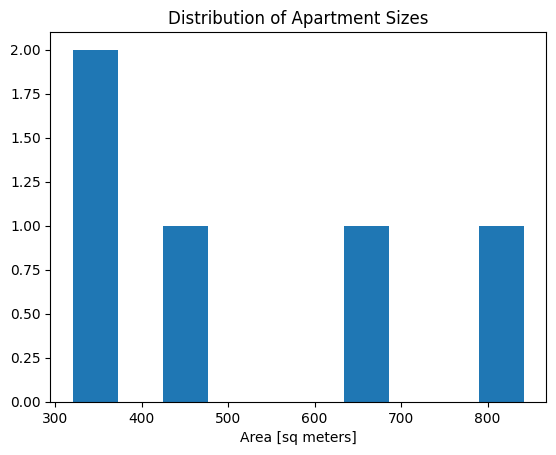

In [5]:
# Plot the distribution of apartment sizes
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes")

In [6]:
# Summary statistics for df
df.describe()['surface_covered_in_m2']

count      5.000000
mean     524.880000
std      230.498128
min      320.500000
25%      324.800000
50%      453.800000
75%      683.300000
max      842.000000
Name: surface_covered_in_m2, dtype: float64

Text(0, 0.5, 'Price [USD]')

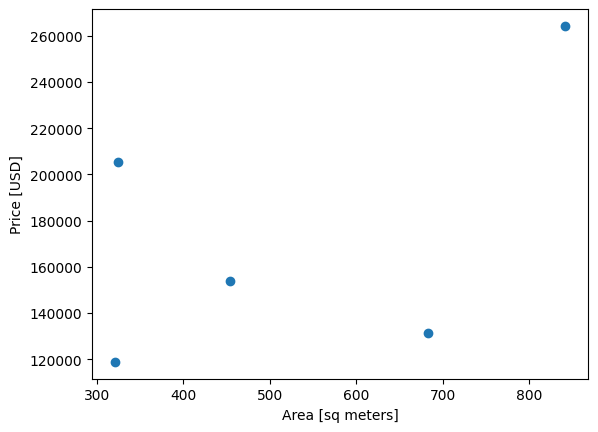

In [8]:
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")